# Simple RL code to teach the model to stand

## Setup jax enviroment and Load Model 

In [1]:
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt

import sys
sys.path.append("../Biodiffrl")

import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".60"

# Optionally, force JAX to preallocate memory.
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Setup environment variable for Nvidia GPU acceleration
os.environ['XLA_FLAGS'] = (
    # '--xla_gpu_enable_triton_softmax_fusion=true '
    '--xla_gpu_triton_gemm_any=True '
    # '--xla_gpu_enable_async_collectives=true '
    # '--xla_gpu_enable_latency_hiding_scheduler=true '
    '--xla_gpu_enable_highest_priority_async_stream=true '
    # '--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=32'
)

backend = 'gpu'
# backend = 'METAL'
# backend = 'cpu'

import jax
jax.config.update('jax_platform_name', 'gpu')
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_lazy_compilation=false"
# Enable compliation catch
os.environ["JAX_COMPILATION_CACHE_DIR"] = "./jax_cache"
jax.config.update("jax_compilation_cache_dir", "./jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", 0)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 2)
# jax.config.update("jax_explain_cache_misses", True)

from jax.experimental.compilation_cache import compilation_cache as cc
cc.set_cache_dir("./jax_cache")
# Debug Nan
# jax.config.update("jax_debug_nans", True)

from jax import numpy as jp
# More legible printing from numpy.
jp.set_printoptions(precision=4, suppress=True, linewidth=100)

import mujoco
import mujoco.mjx as mjx
from mujoco.mjx._src import scan
from mujoco.mjx._src import types

# More legible printing from numpy.
np.set_printoptions(precision=4, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

device = jax.devices(backend=backend)[0]

model_path = '/home/bugman/Currentwork/biomujoco_converter/converted/mjc/Gait2354/gait2354_cvt1.xml'

# Single step
mjx_step = jax.jit(mjx.step, backend=backend)



# mjx_multiple_steps = jax.jit(multiple_steps, backend=backend, )

## Load Model

In [2]:
from mujoco.mjx._src.biomtu import acceleration_mtu

mj_model = mujoco.MjModel.from_xml_path(model_path)
mjx_model = mjx.put_model(mj_model,device=device)

# Disable tendon
opt = mjx_model.opt.replace(disableflags = mjx_model.opt.disableflags |mujoco.mjtDisableBit.mjDSBL_PASSIVE)
mjx_model = mjx_model.replace(opt=opt)

mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Load the Keyframe
mjx_data = mjx_data.replace(qpos = mj_model.key_qpos[0])
mj_data.qpos = mj_model.key_qpos[0]

# Calculate equilibrum
mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)
mjx_data = jax.jit(mjx_step)(mjx_model, mjx_data)

init_mjx_data = mjx_data

def print_all():
    print(mjx_model.biomtu_adr)
    print(mjx_model.mtu_wrap_objid)
    print(mjx_model.mtu_wrap_type)
    print(mjx_model.biomtu_fiso)
    print(mjx_model.biomtu_vmax)
    print(mjx_model.biomtu_ofl)
    print(mjx_model.biomtu_opa)
    print(mjx_model.biomtu_mass)
    print("-------Data--------")
    print("qpos:", mjx_data.qpos)
    print("mtu l:", mjx_data.biomtu.l)
    print("tendon l:", mjx_data.biomtu.tendon_l)
    print("fiber l :", mjx_data.biomtu.fiber_l)
    print("Muscle Bce:", mjx_data.biomtu.B_ce)
    print("Muscle vm:", mjx_data.biomtu.m)
    print("Fiber acc:", mjx_data.biomtu.fiber_acc)
    print("Fiber v:", mjx_data.biomtu.fiber_v)
    print("Biomtu h:", mjx_data.biomtu.h)
    print(mjx_data.biomtu.v)
    print(mjx_data.biomtu.h)  # The constant high of the muscle.
    print(mjx_data.biomtu.pennation_angle)
    print(mjx_data.biomtu.origin_body_id)
    print(mjx_data.biomtu.insertion_body_id)
    print("mtu act:", mjx_data.biomtu.act)
    # print(mjx_data.biomtu.j)
    print(mjx_data.qfrc_biomtu)
    print(mj_model.key_time)
    print(mj_model.key_qpos)
    print(mj_model.key_qvel)

# print_all()

print(mjx_model.nbiomtu)
print(mjx_model.nq)
print(mjx_data.qpos)
print(mjx_data.qvel)

54
27
[ 0.      0.9501  0.      0.0006  0.     -0.     -0.0013 -0.     -0.0009 -0.0037 -0.3957  0.0023
 -0.0199 -0.0032  0.0228 -0.0013 -0.     -0.0009 -0.0037 -0.3957  0.0023 -0.0199 -0.0032  0.0228
 -0.0007 -0.      0.    ]
[ 0.0149  0.0271  0.      0.3064  0.     -0.     -0.6693 -0.0194 -0.4365 -0.0074  0.0056  1.1327
 -9.9627 -1.625  11.377  -0.6693 -0.0194 -0.4365 -0.0074  0.0056  1.1327 -9.9628 -1.625  11.377
 -0.3256 -0.      0.    ]


## Neural Networks

In [3]:
import nn

key = jax.random.key(2024)
# Controller NN
controller_nn = nn.Controller_NN(mjx_model.nq*2+mjx_model.nbiomtu*2, mjx_model.nbiomtu)
controller_params, key = controller_nn.init_parameters(key)
controller = controller_nn.get_fn()

# Critic NN
critic_nn = nn.Critic_NN(mjx_model.nq*2 + mjx_model.nbiomtu*2,1)
critic_params, key = critic_nn.init_parameters(key)
criticer = critic_nn.get_fn()

# Test the two neural networks
controller_output = controller(controller_params, jp.ones(mjx_model.nq*2+mjx_model.nbiomtu*2), key)
print(controller_output[0].shape)
print(controller_output)
print(criticer(critic_params, jp.ones(mjx_model.nq*2+mjx_model.nbiomtu*2)))

(54,)
(Array([0.1488, 0.    , 0.0987, 0.2666, 0.    , 0.2967, 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.1996, 0.2439, 0.    , 0.    , 0.    , 0.215 , 0.3028, 0.    , 0.    ,
       0.2961, 0.    , 0.4897, 0.598 , 0.    , 0.    , 0.1105, 0.    , 0.3579, 0.3427, 0.    ,
       0.    , 0.1568, 0.355 , 0.194 , 0.    , 0.    , 0.1536, 0.    , 0.    , 0.1321, 0.6448,
       0.    , 0.2723, 0.    , 0.    , 0.    , 0.0218, 0.    , 0.2099, 0.    , 0.    ],      dtype=float32), Array([0.2006, 0.0239, 0.1653, 0.3102, 0.    , 0.3476, 0.    , 0.    , 0.0396, 0.    , 0.    ,
       0.    , 0.    , 0.2458, 0.2882, 0.    , 0.    , 0.    , 0.2859, 0.346 , 0.    , 0.    ,
       0.3306, 0.    , 0.5448, 0.6572, 0.    , 0.0215, 0.1492, 0.    , 0.4006, 0.3831, 0.    ,
       0.    , 0.2316, 0.3897, 0.2437, 0.    , 0.    , 0.2122, 0.    , 0.    , 0.1918, 0.6812,
       0.    , 0.2966, 0.    , 0.    , 0.    , 0.0958, 0.    , 0.284 , 0.    , 0.    ],      dtype=float32), Array([ 0.0455,

## Environment Control

In [4]:
from functools import partial
# Since the environment resets with init_mjx_data, the muscles are already in the equilibrum condition.
def reset(init_mjx_data, batch_size):
    new_data = jax.tree.map(
        partial(jp.repeat, repeats=batch_size, axis=0),
        jax.tree.map(partial(jp.expand_dims, axis=0),init_mjx_data))
    return new_data

def random_init(data, model, rng: jax.Array):
    nbiomtu = model.nq
    init_qpos = data.qpos
    init_qvel = data.qvel
    new_rng, rng1, rng2 = jax.random.split(rng, 3)
    # Qpos_1 is the vertical position
    random_qpos = init_qpos + jax.random.uniform(rng1, [nbiomtu], minval=jp.array(-1.0, dtype=jp.float32), maxval=jp.array(1.0, dtype=jp.float32))*0.01
    random_qvel = init_qvel + jax.random.uniform(rng2, [nbiomtu], minval=jp.array(-1.0, dtype=jp.float32), maxval=jp.array(1.0, dtype=jp.float32))*0.01
    newdata = data.replace(qpos=random_qpos)
    newdata = newdata.replace(qvel=random_qvel)
    newdata = mjx.forward(mjx_model, newdata)
    # print('data:',data.qpos, data.qvel)
    # Calculate equilibrum
    # newdata = acceleration_mtu.calc_equilibrium(mjx_model, newdata)
    # newdata = mjx_step(mjx_model, newdata)
    return newdata, new_rng

vrandom_init = jax.jit(jax.vmap(random_init, in_axes=(None, None, 0), out_axes=0))
    

## Multi-steps forward simulation

In [ ]:
import exp

# Multiple steps
def step_fn(carry, _):
    model, data= carry
    new_data = mjx.step(model, data)
    new_carry = (model, new_data)
    return new_carry, _

def multiple_steps(model, data):
    init_carry = (model, data)
    y, _ = jax.lax.scan(step_fn, init_carry, None, length=10)
    new_data = y[0]
    return new_data

# For one step
def nn_mjx_one_step(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    new_data = mjx.step(model, data)
    return new_data, new_key, act

def nn_mjx_perturbe_one_step(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    xfrc = jax.random.normal(key,(mjx_model.nbody, 6))*1.0
    data = data.replace(xfrc_applied=xfrc)
    new_data = mjx.step(model, data)
    return new_data, new_key, act

@jax.jit
def jit_nn_mjx_one_step_no_random(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    new_data = mjx.step(model, data)
    return new_data, new_key, mean

def nn_step_fn(carry, _):
    nn_params, model, data, key = carry
    new_data, new_key, act = nn_mjx_one_step(nn_params, model, data, key)
    # new_data, new_key, act = nn_mjx_perturbe_one_step(nn_params, model, data, key)
    new_carry = (nn_params, model, new_data, new_key)
    # Calculate reward
    head_height = new_data.sensordata[2]
    state = jp.concat([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    next_state = jp.concat([new_data.qpos, new_data.qvel, new_data.biomtu.fiber_l, new_data.biomtu.fiber_v])
    action = act
    # done = head_hight < 1.2
    done = jp.where(head_height <= 1, jp.float32(1), jp.float32(0))
    reward = -(head_height-1.63)**2 - done*2
    experience = exp.experience(state, next_state, action, reward, done)
    
    return new_carry, experience

@jax.jit
def nn_multi_steps(nn_params, model, data, key):
    # Also deal with the done in the experience pool
    
    repeat_length = 50  # Simulate for 0.1s
    init_carry = (nn_params, model, data, key)
    y, experience = jax.lax.scan(nn_step_fn, init_carry, None, length=repeat_length)
    new_data = y[2]
    new_key = y[3]
    return new_data, new_key, experience

jit_nn_multi_steps = jax.jit(nn_multi_steps)

# @jax.jit
def v_nn_multi_steps(nn_params, model, data, keys):
    return jax.vmap(nn_multi_steps, in_axes=(None, None, 0, 0))(nn_params, model, data, keys)

jit_v_nn_multi_steps = jax.jit(v_nn_multi_steps)




In [6]:
# Settings
import exp

critic_batch_size = 64*10
controller_batch_size = 64
key = jax.random.key(2024)
keys = jax.random.split(key, controller_batch_size)

memory_settings = exp.memory_settings(critic_batch_size*126, mjx_model.nq*2+mjx_model.nbiomtu*2, mjx_model.nbiomtu, 1)

### Generate initial experience

In [7]:
exp_pool = None
datas = jax.jit(reset,static_argnames="batch_size")(init_mjx_data, controller_batch_size)
init_data_batch = datas
for i in range(5):
    datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)
    
print(exp_pool.states.shape)

(16000, 162)


## Prepare Critic gradient

In [8]:
import optax

v_criticer = jax.vmap(criticer,in_axes=(None, 0))
jit_v_criticer = jax.jit(v_criticer)

def critic_loss(params, batch):
    discount = 0.95
    states = batch.states
    next_states = batch.next_states
    actions = batch.actions
    rewards = batch.rewards
    
    critic_score = v_criticer(params, states)
    # target = rewards + discount* jax.lax.stop_gradient(v_criticer(params, next_states))
    target = rewards + discount* (v_criticer(params, next_states))
    
    loss = optax.l2_loss(critic_score, target)
    loss = jp.mean(loss)
    return loss

sample_batch = exp.memory.sample(exp_pool, critic_batch_size, key)
critic_loss_g_value_lower= jax.jit(jax.value_and_grad(critic_loss)).lower(critic_params, sample_batch)

jit_critic_loss_g_value = critic_loss_g_value_lower.compile()
a=jit_critic_loss_g_value.cost_analysis()[0]['flops']
print(a)

19671028.0


## Prepare Actor gradient

In [9]:
def controller_loss_and_experience(controller_params, critic_params, batch, batch_size, mjx_model, init_data_batch, keys):
    # Generate data for simulation
    nq = mjx_model.nq
    nmtu = mjx_model.nbiomtu
    
    # Deal with the done state, reset the done state with init state
    # exp_data_batch = init_data_batch.replace(
    #     qpos = batch.states[:,0:nq], 
    #     qvel = batch.states[:,nq:nq*2],
    #     biomtu = init_data_batch.biomtu.replace(
    #         fiber_l = batch.states[nq*2, nq*2+nmtu],
    #         fiber_v = batch.states[nq*2+nmtu, nq*2+nmtu*2]
    #     ))
    
    qpos = jp.where(batch.dones, init_data_batch.qpos, batch.states[:,0:nq])
    qvel = jp.where(batch.dones, init_data_batch.qvel, batch.states[:,nq:nq*2])
    fiber_l = jp.where(batch.dones, init_data_batch.biomtu.fiber_l, batch.states[:,nq*2 : nq*2+nmtu])
    fiber_v = jp.where(batch.dones, init_data_batch.biomtu.fiber_v, batch.states[:,nq*2+nmtu : nq*2+nmtu*2])
    
    # in_data = batch.dones, init_data_batch, exp_data_batch)
    
    in_data = jax.lax.stop_gradient(init_data_batch.replace(
        qpos = qpos,
        qvel = qvel,
        biomtu = init_data_batch.biomtu.replace(
            fiber_l = fiber_l,
            fiber_v = fiber_v)
        )
    )
    
    out_data, keys, new_exps = v_nn_multi_steps(controller_params, mjx_model, in_data, keys)
    # out_states = jp.concat([out_data.qpos, out_data.qvel],axis=1).reshape(batch_size,4)
    out_states = new_exps.next_states
    # jax.debug.print("out_states shape{0}", out_states.shape)
    # out_states = jp.concat([out_data.qpos, out_data.qvel, out_data.biomtu.fiber_l, out_data.biomtu.fiber_v],axis=1)
    critic_score = v_criticer(critic_params, out_states)
    
    loss = -jp.mean(critic_score)
    return loss, new_exps

# The function calculating the loss of the controller and also generate experiences
g_loss_experience = jax.value_and_grad(controller_loss_and_experience, has_aux=True)

controller_keys = jax.random.split(key, controller_batch_size)
sample_batch = exp.memory.sample(exp_pool, controller_batch_size, key)

print("lowering")
g_loss_experience_lower = jax.jit(g_loss_experience, static_argnames=["batch_size"]).lower(
    controller_params, 
    critic_params, 
    sample_batch, 
    controller_batch_size, 
    mjx_model, 
    init_data_batch, 
    controller_keys)

print("compiling")
jit_g_loss_experience = g_loss_experience_lower.compile()

b = jit_g_loss_experience.cost_analysis()[0]['flops']
print(b)

lowering
compiling
290555872.0


In [10]:
print(sample_batch.states.shape)
print(b/a)

(64, 162)
14.770751787857757


## Train the two neural networks

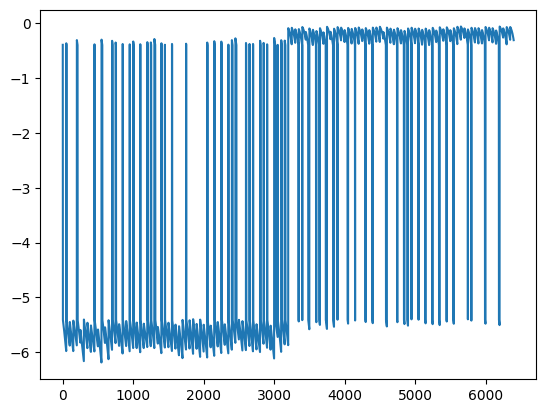

In [ ]:
key = jax.random.key(934346)
keys = jax.random.split(key, controller_batch_size)

critic_params, key = critic_nn.init_parameters(key)
critic_tx = optax.apply_if_finite(optax.adam(learning_rate=1e-5), max_consecutive_errors=50)
# critic_tx = optax.apply_if_finite(optax.sgd(learning_rate=1e-4), max_consecutive_errors=50)
critic_opt_state = critic_tx.init(critic_params)
jit_critic_tx_update = jax.jit(critic_tx.update)


controller_params, key = controller_nn.init_parameters(key)
controller_tx = optax.apply_if_finite(optax.adam(learning_rate=1e-5), max_consecutive_errors=50)
# controller_tx = optax.apply_if_finite(optax.sgd(learning_rate=1e-4), max_consecutive_errors=50)
controller_opt_state = controller_tx.init(controller_params)
jit_controller_tx_update = jax.jit(controller_tx.update)

jit_apply_update = jax.jit(optax.apply_updates)


jit_sample = jax.jit(exp.memory.sample, static_argnames="batch_size")
jit_add_exp = jax.jit(exp.memory.add_exp, static_argnames="settings")

# Init exp_pool
exp_pool = None
datas = reset(init_mjx_data,controller_batch_size)
for i in range(6):
    datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    if(i>2):
        exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)

#plot exp_pool
# plt.plot(exp_pool.states.T[1])
plt.plot(exp_pool.rewards)

---------- 0 ----------
criticer loss: 7.460624
Controller Loss: 2.2138326
mean rewards: -1.162677
mean score: -2.2050295
scorc/reward: 1.8965107
death rate: 0.1978125
best_death_rate: 0.1978125
---------- 1 ----------
criticer loss: 5.892363
Controller Loss: 4.8518806
mean rewards: -1.1128913
mean score: -4.8238163
scorc/reward: 4.33449
death rate: 0.1940625
best_death_rate: 0.1940625
---------- 2 ----------
criticer loss: 4.859965
Controller Loss: 7.8701534
mean rewards: -1.3141277
mean score: -7.8175707
scorc/reward: 5.948867
death rate: 0.20510416
best_death_rate: 0.1940625
---------- 3 ----------
criticer loss: 3.6879158
Controller Loss: 10.545725
mean rewards: -1.1555574
mean score: -10.458673
scorc/reward: 9.05076
death rate: 0.20375
best_death_rate: 0.1940625
---------- 4 ----------
criticer loss: 2.9727986
Controller Loss: 13.938796
mean rewards: -0.8969673
mean score: -13.787508
scorc/reward: 15.37125
death rate: 0.194125
best_death_rate: 0.1940625
---------- 5 ----------
cri

/tmp/ipykernel_1809921/1101788389.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Controller Loss: 5.1833177
mean rewards: -0.42783156
mean score: -5.110758
scorc/reward: 11.9457245
death rate: 0.0625
best_death_rate: 0.021431249
---------- 402 ----------
criticer loss: 0.4074483
Controller Loss: 7.8371506
mean rewards: -0.36153492
mean score: -7.7322545
scorc/reward: 21.387297
death rate: 0.062393747
best_death_rate: 0.021431249
---------- 403 ----------
criticer loss: 0.41638738
Controller Loss: 7.274205
mean rewards: -0.6306366
mean score: -7.207363
scorc/reward: 11.428711
death rate: 0.06385
best_death_rate: 0.021431249
---------- 404 ----------
criticer loss: 0.4775281
Controller Loss: 6.7696667
mean rewards: -0.5498931
mean score: -6.6548667
scorc/reward: 12.10211
death rate: 0.06396875
best_death_rate: 0.021431249
---------- 405 ----------
criticer loss: 0.39659676
Controller Loss: 3.627699
mean rewards: -0.34279284
mean score: -3.5729363
scorc/reward: 10.423019
death rate: 0.062612504
best_death_rate: 0.021431249
---------- 406 ----------
criticer loss: 0.49

KeyboardInterrupt: 

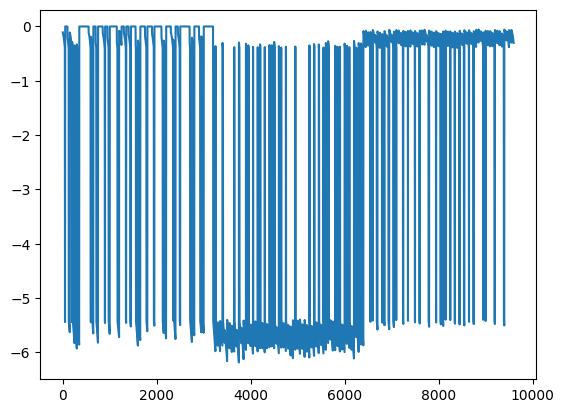

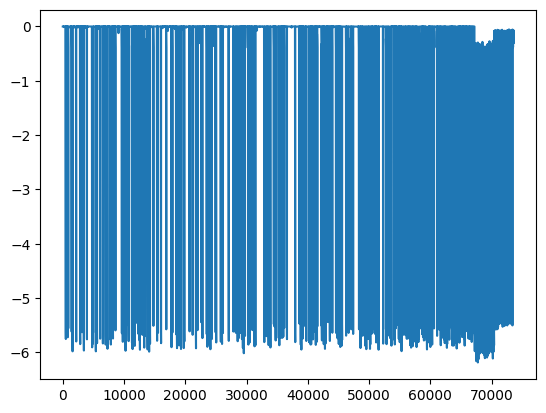

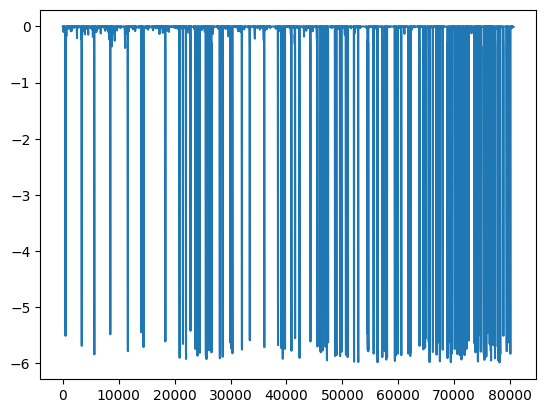

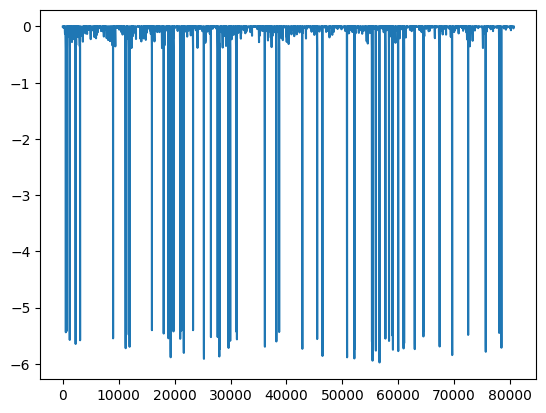

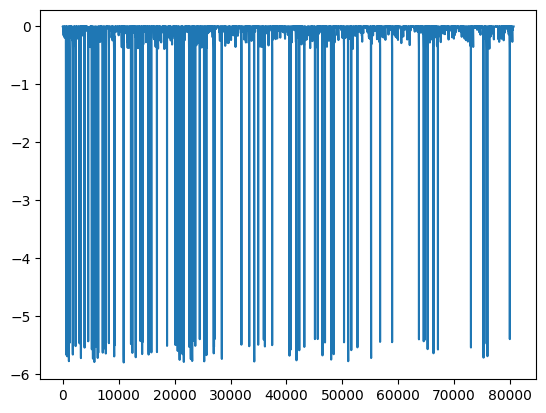

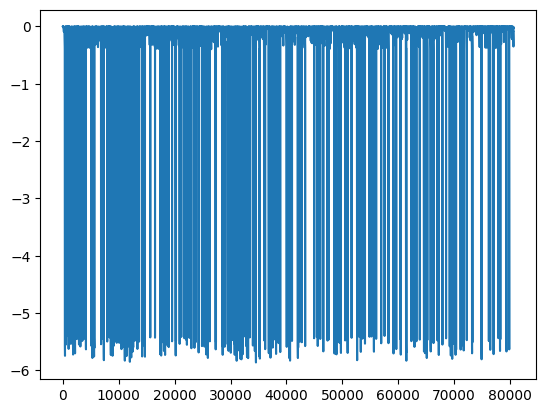

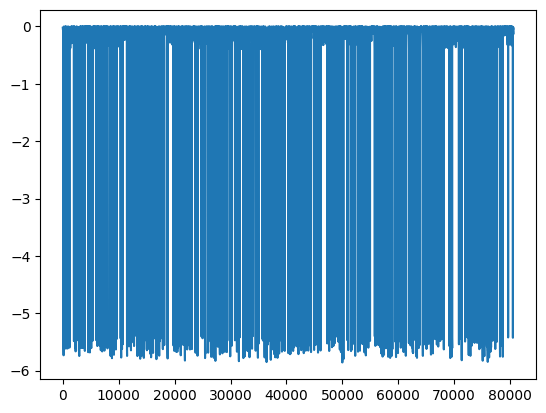

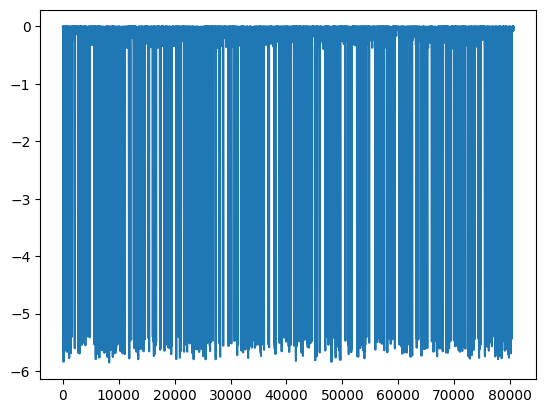

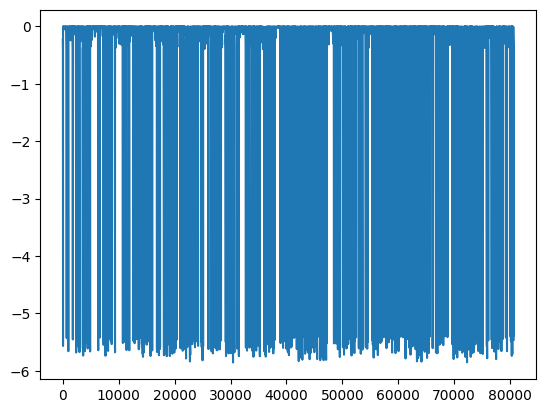

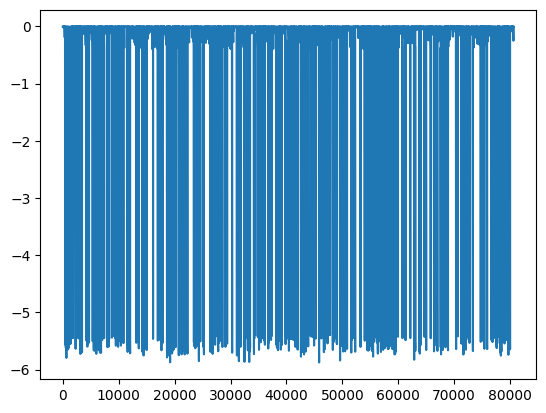

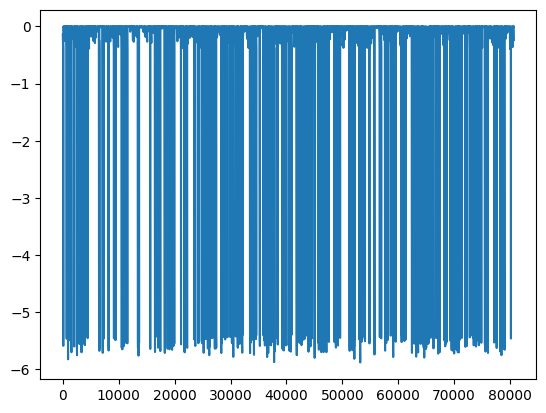

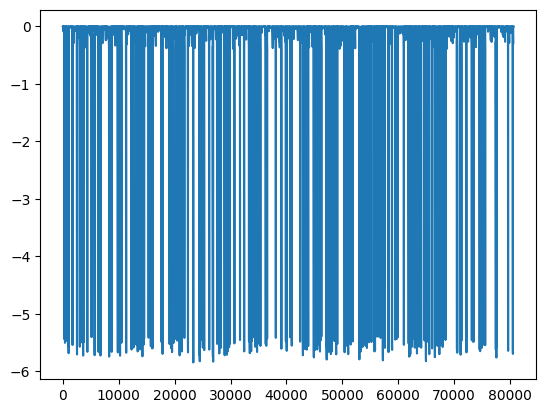

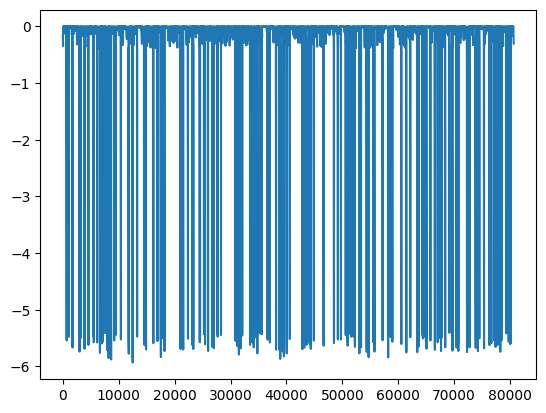

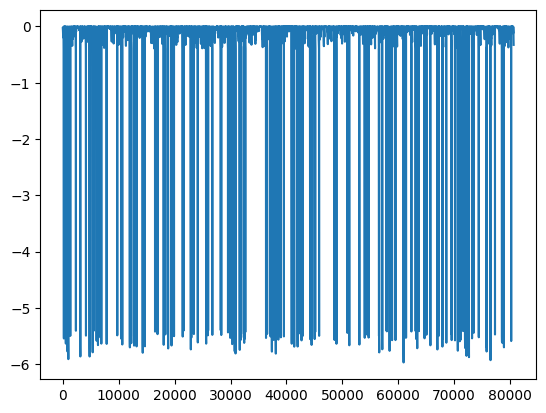

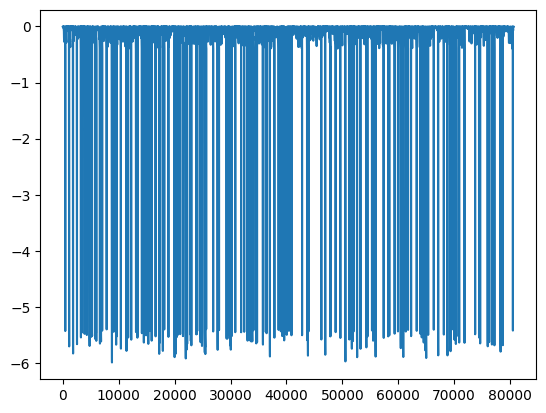

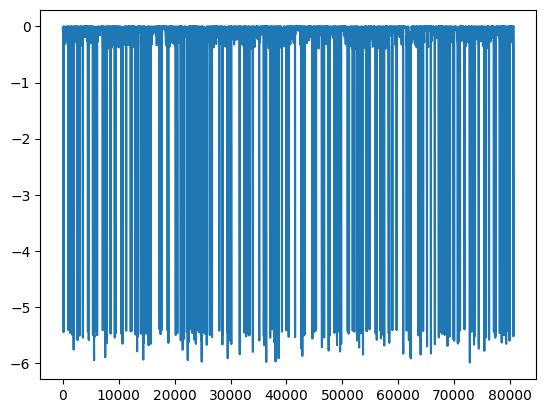

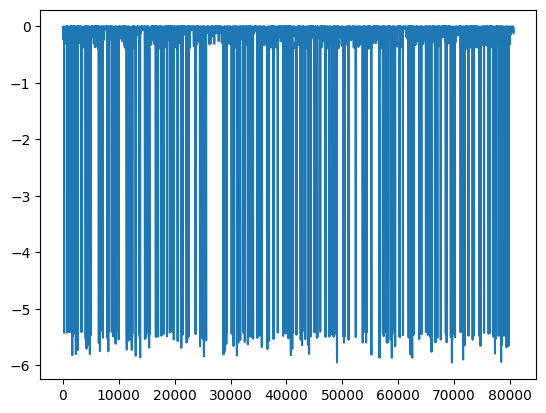

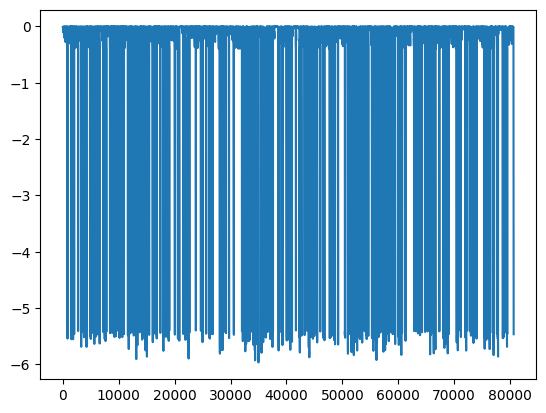

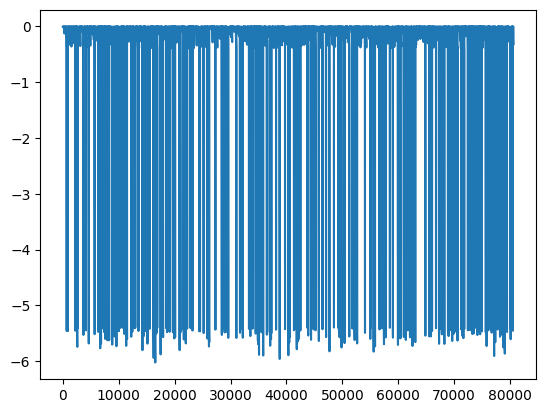

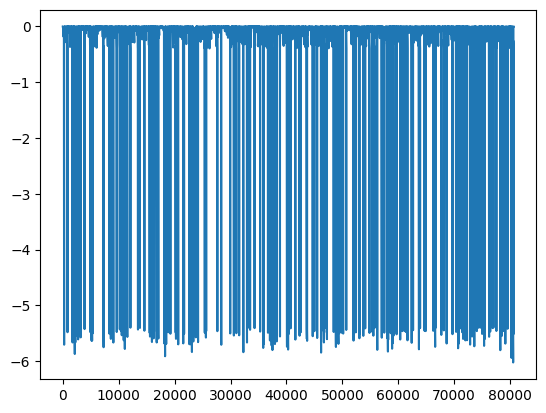

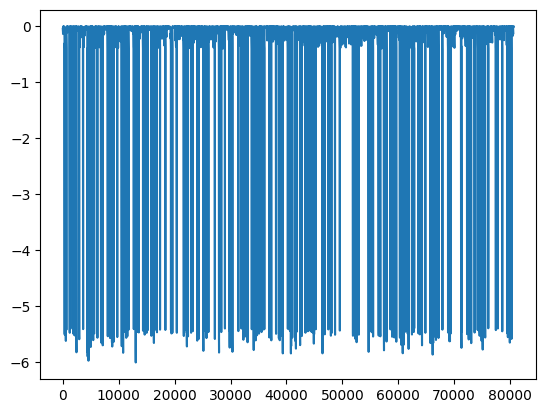

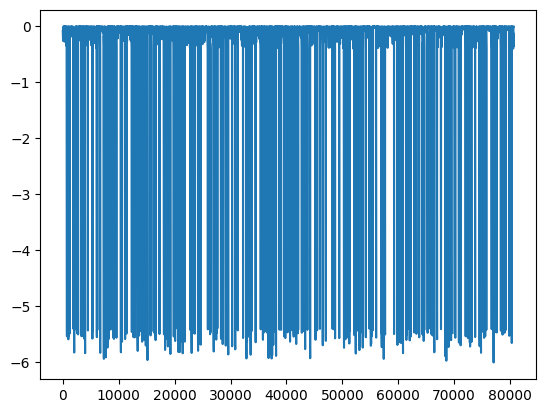

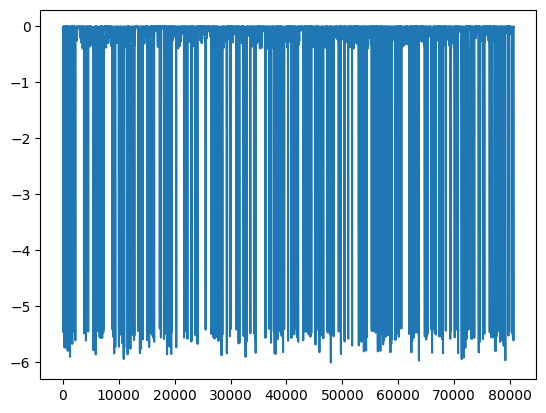

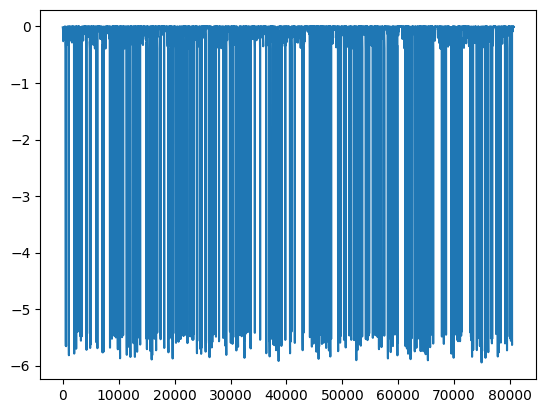

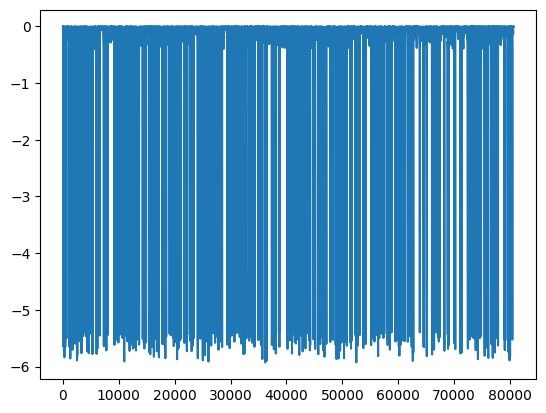

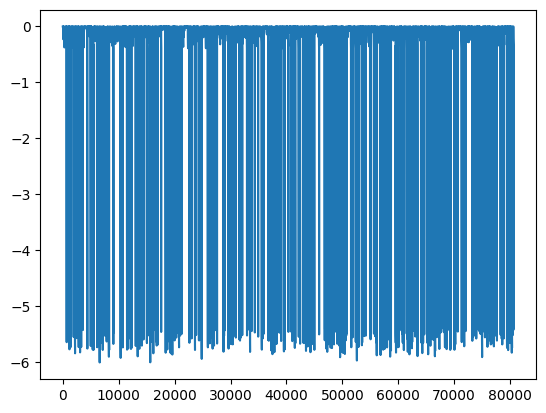

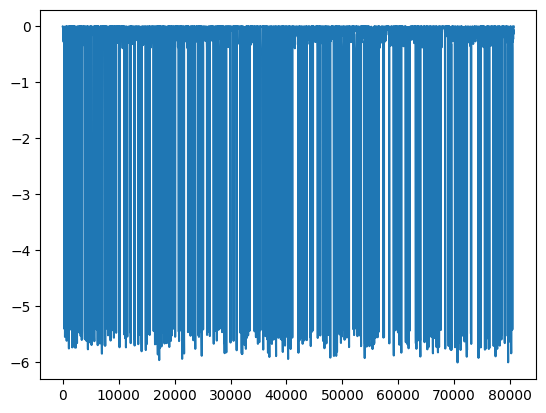

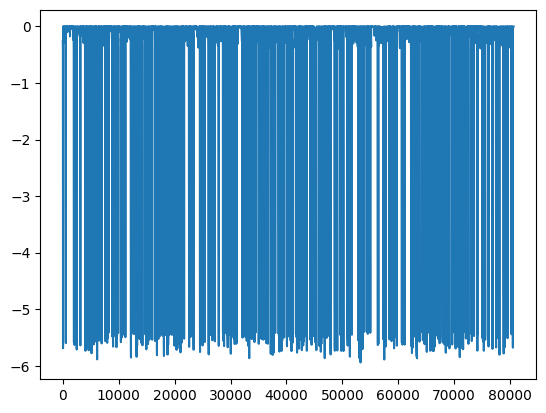

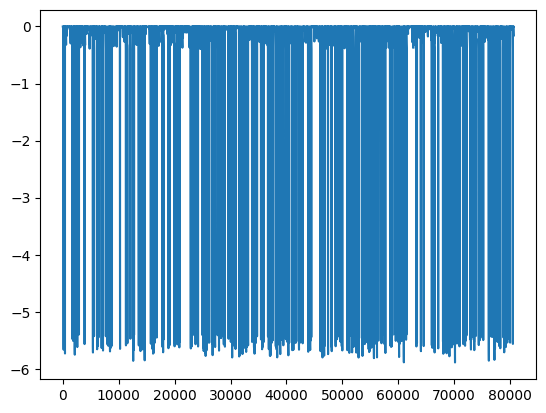

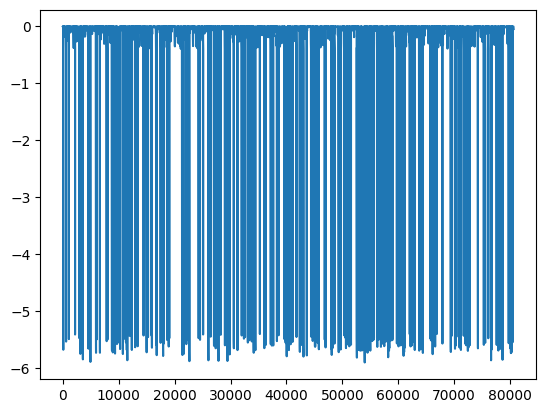

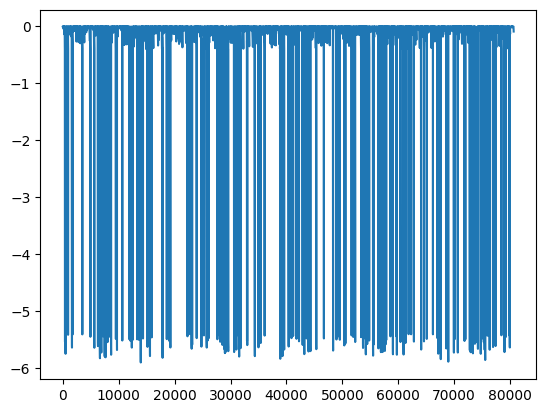

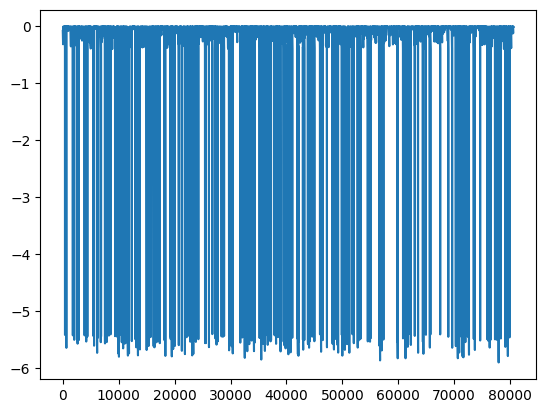

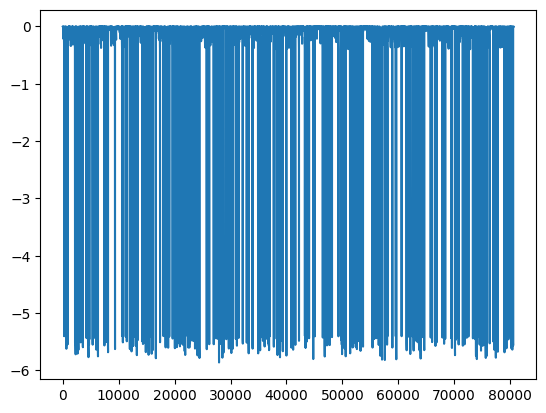

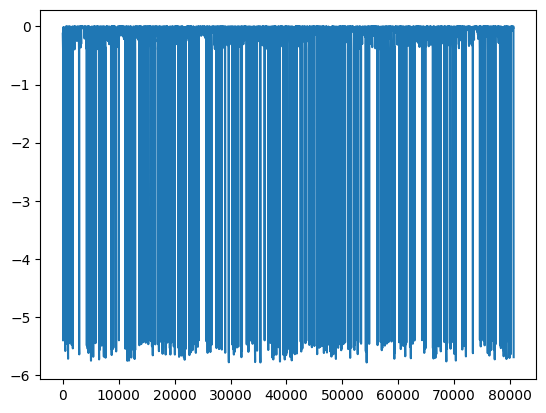

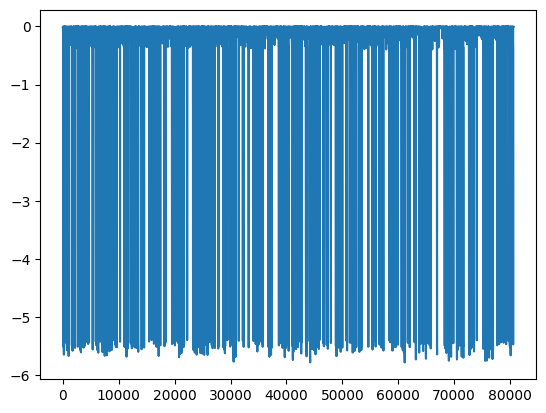

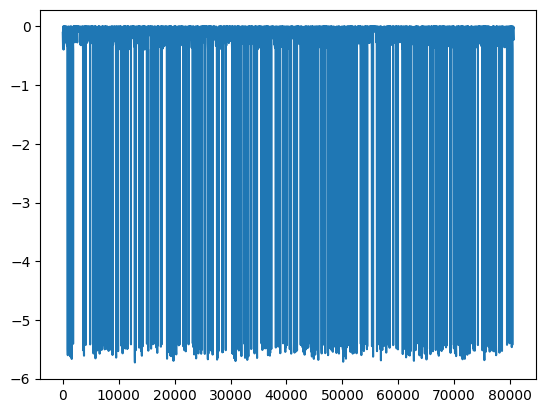

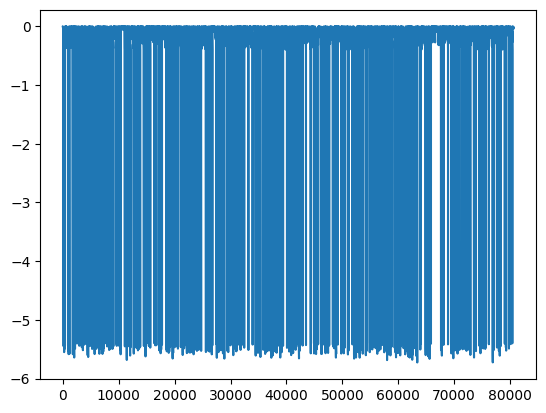

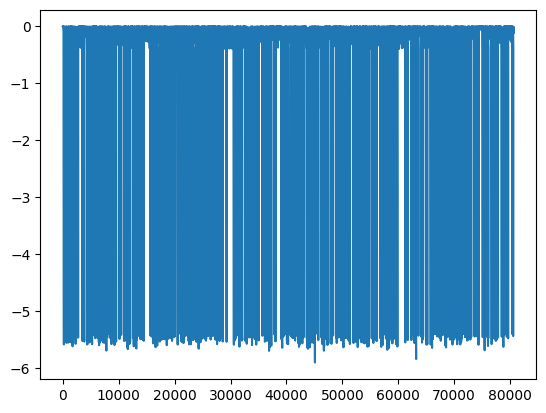

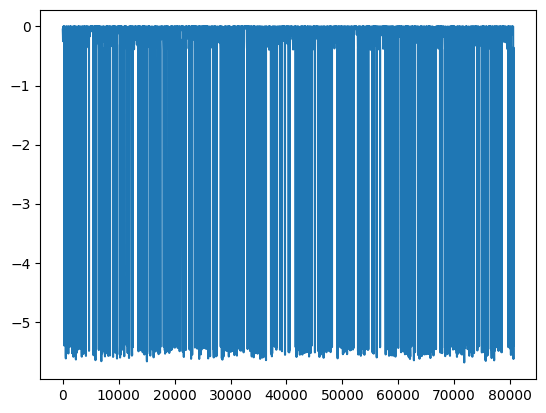

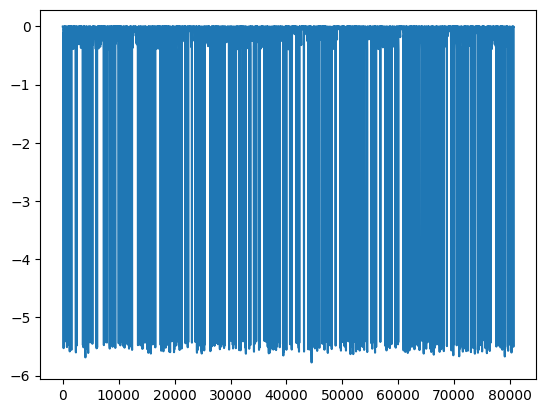

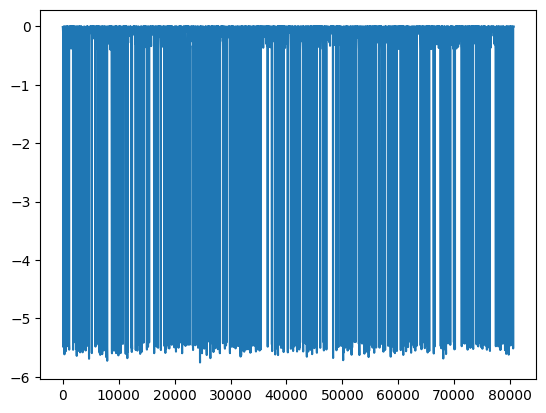

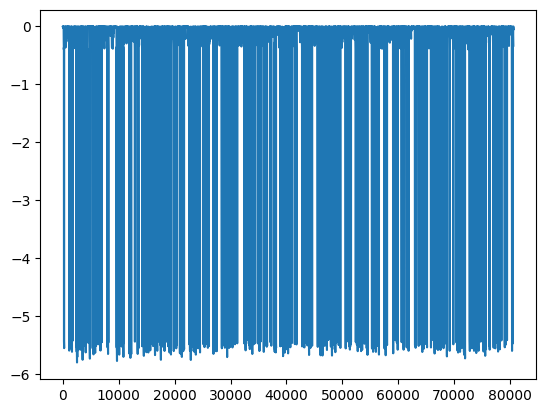

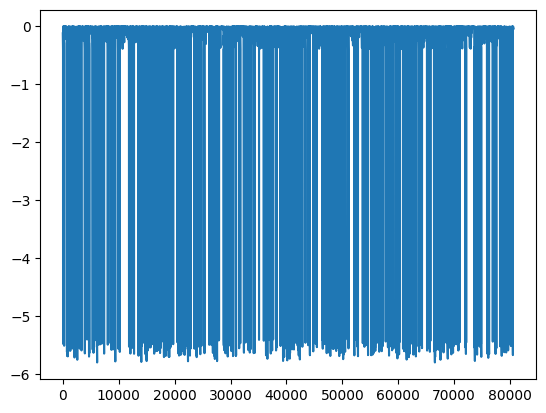

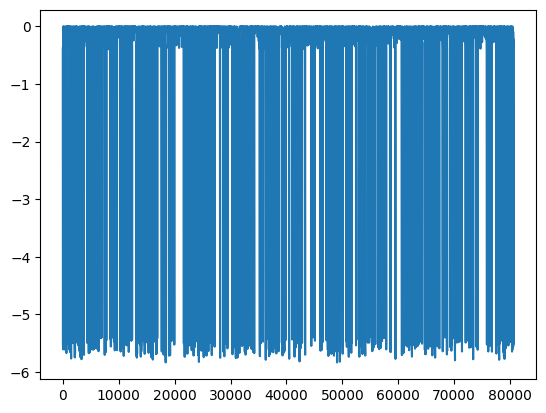

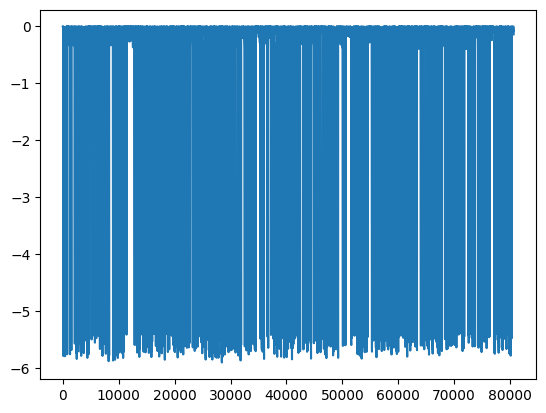

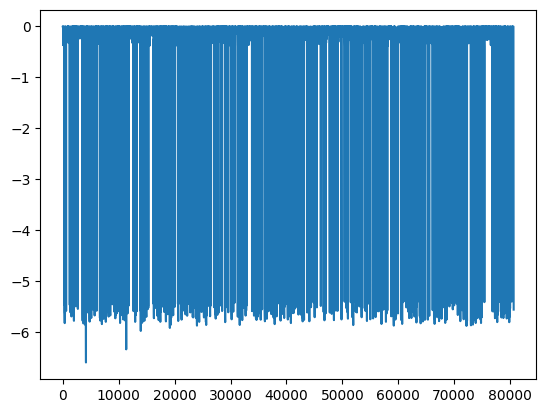

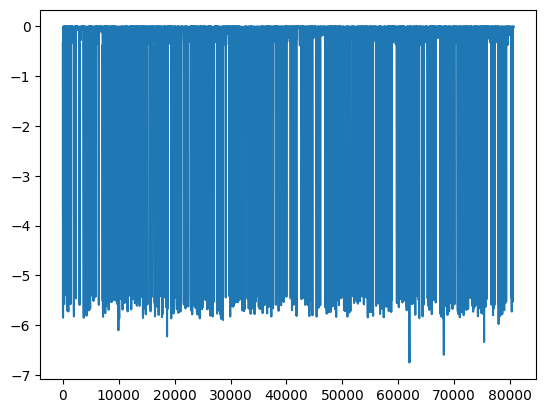

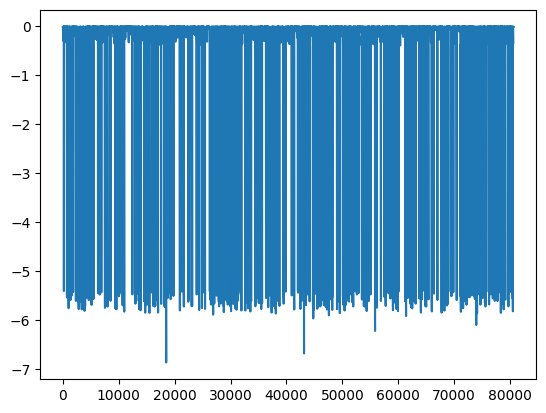

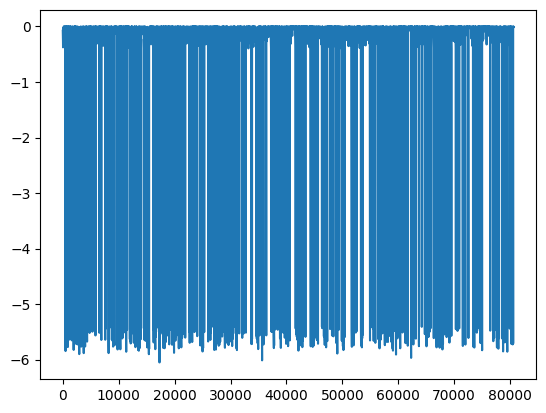

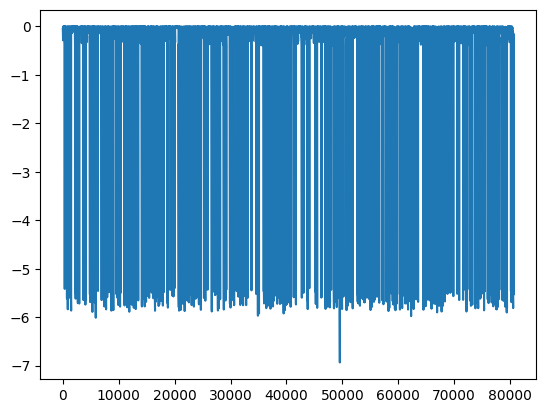

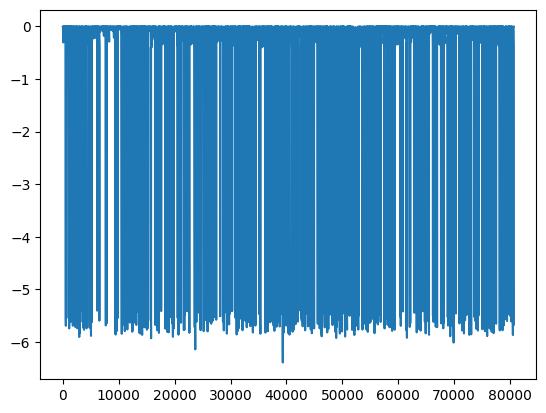

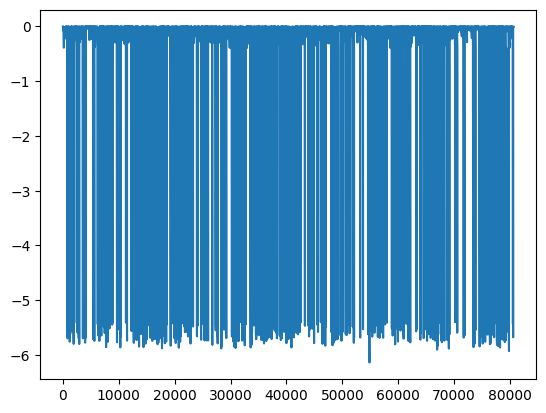

In [12]:
# Debug Nan
# jax.config.update("jax_debug_nans", True)

import exp


death_rate_buf = []
best_death_rate = 0.5

for i in range(4000):

    print("----------",i,"----------")
    
    criric_repeat = 16
    if(i == 500):
        criric_repeat = 1
        
    for j in range(criric_repeat):
        batch = jit_sample(exp_pool, critic_batch_size, key)
        key = jax.random.split(key, 1)[0]
        
        # criticer
        critic_loss, critic_loss_grad = jit_critic_loss_g_value(critic_params, batch)
        
        # Update params
        critic_updates, critic_opt_state = jit_critic_tx_update(critic_loss_grad, critic_opt_state)
        critic_params = jit_apply_update(critic_params, critic_updates)
    
    print("criticer loss:",critic_loss)
    # controller
    
    # for j in range(3):
    keys = jax.random.split(key,controller_batch_size)
    controller_batch = jit_sample(exp_pool, controller_batch_size, key)
    key = jax.random.split(key, 1)[0]
    controller_loss_exps, controller_loss_grad = jit_g_loss_experience(
        controller_params, critic_params, controller_batch, mjx_model, init_data_batch, keys)
    controller_loss = controller_loss_exps[0]
    exps = controller_loss_exps[1]
        
    # Update params
    controller_updates, controller_opt_state = jit_controller_tx_update(controller_loss_grad, controller_opt_state)
    controller_params = jit_apply_update(controller_params, controller_updates)
    
    exp_pool = jit_add_exp(memory_settings, exp_pool, exps)
    
    # Count Dones
    death_rate_buf.insert(0, jp.count_nonzero( exps.dones)/(exps.dones.shape[1]*controller_batch_size))
    death_rate_buf = death_rate_buf[:50]
    death_rate = np.mean(death_rate_buf)
    
    print("Controller Loss:", controller_loss)
    mean_reward = jp.mean(exps.rewards)
    print("mean rewards:", mean_reward)
    mean_score = jp.mean(jit_v_criticer(critic_params, exps.states))
    print("mean score:", mean_score)
    print("scorc/reward:", mean_score/mean_reward)
    print("death rate:", death_rate)
    
    if(best_death_rate > death_rate): best_death_rate = death_rate
    print("best_death_rate:", best_death_rate)
    # add exps
    
    if(i%20 == 0):
        plt.figure()
        plt.plot(exp_pool.rewards)
        plt.plot()
        # plt.plot(exp_pool.rewards)

## Visualize the model and controller

In [ ]:
import mujoco.viewer
import time


# Disable tendon
opt = mjx_model.opt.replace(disableflags = mjx_model.opt.disableflags |mujoco.mjtDisableBit.mjDSBL_PASSIVE)
mjx_model = mjx_model.replace(opt=opt)

mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Load the Keyframe
mjx_data = mjx_data.replace(qpos = mj_model.key_qpos[0])
mj_data.qpos = mj_model.key_qpos[0]

# Calculate equilibrum
mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)

previous_frame_time = time.time()
i = 0
key = jax.random.key(334)
with mujoco.viewer.launch_passive(mj_model, mj_data) as viewer:
    while viewer.is_running():
        # Update mjx_data from mj_data. The mj_data was modified by the viewer
        # mjx_data = mjx_data.replace(ctrl=mj_data.ctrl, xfrc_applied=mj_data.xfrc_applied)
        # Use the nerual network to generate ctrl signal
        
        mjx_data = mjx_data.replace(xfrc_applied=jp.array(mj_data.xfrc_applied, dtype=jp.float32))
        
        # Generate key
        key = jax.random.split(key,1)[0]
        # xfrc = jax.random.uniform(key,(mjx_model.nbody, 6), minval=-10, maxval=10)
        # mjx_data = mjx_data.replace(xfrc_applied=xfrc)
        mjx_data = mjx_data.replace(
            qpos= jp.array(mj_data.qpos, dtype=jp.float32),
            qvel= jp.array(mj_data.qvel, dtype=jp.float32),
            time = jp.array(mj_data.time, dtype=jp.float32))
        
        # Update mjx_model from mj_model
        mjx_model = mjx_model.tree_replace({
            'opt.gravity': jp.array(mj_model.opt.gravity, dtype=jp.float32),
            'opt.tolerance': jp.array(mj_model.opt.tolerance, dtype=jp.float32),
            'opt.ls_tolerance': jp.array(mj_model.opt.ls_tolerance, dtype=jp.float32),
            'opt.timestep': jp.array(mj_model.opt.timestep, dtype=jp.float32),
        })
        
        # mjx_data = mjx_step(mjx_model, mjx_data)
        # mjx_data, loss, exps = jit_nn_multi_steps(controller_params, mjx_model, mjx_data, key)
        mjx_data, key, act = jit_nn_mjx_one_step_no_random(controller_params, mjx_model, mjx_data, key)
        mjx.get_data_into(mj_data, mj_model, mjx_data)
        
        # Record the current time at the start of this frame
        current_frame_time = time.time()
    
        # Calculate the difference in time from the last frame
        time_between_frames = current_frame_time - previous_frame_time
    
        # Print the time between frames
        print(f"Time between frames: {time_between_frames} seconds")
        previous_frame_time = current_frame_time
        
        # print("ACT:", mjx_data.biomtu.act)
        # print(mjx_data.qpos)
        # print(mj_data.sen)  
        print(mjx_data.sensordata[2])
        print(mjx_data.biomtu.act)
        # print(len(mjx_data.qvel))
        viewer.sync()